In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
names_text = open("names.txt", "r").read()
words = names_text.splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [ ]:
chars = ["."] + sorted(list(set("".join(words)) - set(["."])))
ctoi = {c: i for i, c in enumerate(chars)}
itoc = {i: c for i, c in enumerate(chars)}
VOCABULARY_SIZE = len(chars)
VOCABULARY_SIZE

27

In [5]:
CONTEXT_LENGTH = 3
X, Y = [], []
for word in words:
    # print(word)
    context = [0] * CONTEXT_LENGTH
    for c in word:
        idx = ctoi[c]
        X.append(context)
        Y.append(idx)
        # print("".join(itoc[i] for i in context), "----->", itoc[idx])
        context = context[1:] + [idx]


# X is a list of contexts and Y is a associated list of characters that follow the context
# for example:
# "abc" -> "d" is represented as [0, 1, 2] -> 3
# where [0, 1, 2] \in X and 3 \in Y
X, Y = torch.tensor(X), torch.tensor(Y)
X.shape

torch.Size([196113, 3])

In [ ]:
EMBEDDING_DIMS = 2
C = torch.randn((VOCABULARY_SIZE, EMBEDDING_DIMS))  # embeddding matrix
C

tensor([[ 1.1582e+00,  2.8537e-01],
        [-4.7771e-01,  8.1168e-01],
        [-1.5410e-01,  1.0545e+00],
        [ 9.2506e-01,  8.3191e-01],
        [-1.5073e+00,  9.0699e-01],
        [ 1.1075e+00,  2.5325e-01],
        [ 2.6496e+00,  2.8510e-01],
        [ 8.1717e-01,  1.5962e+00],
        [ 1.1184e+00,  2.8409e-02],
        [-9.2253e-01, -5.7689e-01],
        [ 1.1788e-01,  9.5394e-01],
        [-1.8485e+00,  1.4292e+00],
        [-9.9515e-01, -1.1280e+00],
        [ 5.2348e-01, -3.1536e-01],
        [-1.0597e+00, -4.3353e-01],
        [ 6.8604e-01,  2.5667e-01],
        [ 8.2838e-04, -3.2009e-01],
        [-1.6261e+00,  2.5576e+00],
        [-1.4274e+00,  7.0065e-01],
        [-9.4583e-01, -1.4818e-03],
        [ 3.0362e-01, -1.1150e+00],
        [-3.8928e-01, -2.8494e-01],
        [ 1.6515e-01,  1.6124e+00],
        [-5.3247e-03, -1.7277e-01],
        [-3.5885e-01, -1.3711e+00],
        [ 5.1720e-01, -8.9043e-02],
        [-9.6788e-01,  5.3928e-01]])

In [ ]:
# How to embedd letter 'c'?
idx = ctoi["c"]
C[idx]

tensor([0.9251, 0.8319])

In [8]:
# How to embedd context 'abc'?
context = [0, 1, 2]
C[[context]]

tensor([[ 1.1582,  0.2854],
        [-0.4777,  0.8117],
        [-0.1541,  1.0545]])

In [9]:
# How to embedd context 'abc' and 'bcd' simultaneously?
contexts = torch.tensor([[0, 1, 2], [1, 2, 3]])
C[contexts]

tensor([[[ 1.1582,  0.2854],
         [-0.4777,  0.8117],
         [-0.1541,  1.0545]],

        [[-0.4777,  0.8117],
         [-0.1541,  1.0545],
         [ 0.9251,  0.8319]]])

In [10]:
# How to embedd all contexts?
embedding = C[X]
embedding.shape

torch.Size([196113, 3, 2])

In [11]:
# Concat all embeddings within a context
embedding = embedding.reshape(len(X), EMBEDDING_DIMS * CONTEXT_LENGTH)
embedding.shape

torch.Size([196113, 6])

In [ ]:
VOCABULARY_SIZE = len(chars)
EMBEDDING_DIMS = 2
CONTEXT_LENGTH = 3
HIDDEN_LAYER = 100


class MLP:
    def __init__(self):
        self.C = torch.randn((VOCABULARY_SIZE, EMBEDDING_DIMS), requires_grad=True)

        self.W1 = torch.randn((EMBEDDING_DIMS * CONTEXT_LENGTH, HIDDEN_LAYER), requires_grad=True)
        self.b1 = torch.randn((HIDDEN_LAYER), requires_grad=True)

        self.W2 = torch.randn(HIDDEN_LAYER, VOCABULARY_SIZE, requires_grad=True)
        self.b2 = torch.randn(VOCABULARY_SIZE, requires_grad=True)

        self.loss = None

    def forward(self, X: torch.tensor) -> torch.tensor:
        X = F.tanh(X @ self.W1 + self.b1)
        X = X @ self.W2 + self.b2
        return X

    def calculate_loss(self, X: torch.tensor, Y: torch.tensor) -> torch.tensor:
        self.loss = F.cross_entropy(X, Y)
        return self.loss

    def backward(self):
        self.W1.grad = None
        self.b1.grad = None
        self.W2.grad = None
        self.b2.grad = None
        self.C.grad = None
        self.loss.backward()

    def update(self, lr: float):
        self.W1.data -= self.W1.grad * lr
        self.b1.data -= self.b1.grad * lr
        self.W2.data -= self.W2.grad * lr
        self.b2.data -= self.b2.grad * lr
        self.C.data -= self.C.grad * lr

    def train(self, X: torch.tensor, Y: torch.tensor, epochs: int, lr: float, batch_size: int):
        for epoch in range(epochs):
            # select mini-batch
            batch_idx = torch.randint(0, len(X), (batch_size,))
            X_train = X[batch_idx]
            y_train = Y[batch_idx]

            embedded = self.embedd(X_train)
            logits = self.forward(embedded)
            self.calculate_loss(logits, y_train)
            self.backward()
            self.update(lr)
            # print(f"{epoch=}, loss={self.loss.item()}")

    def embedd(self, X: torch.tensor) -> torch.tensor:
        X = self.C[X]
        return X.view(-1, EMBEDDING_DIMS * CONTEXT_LENGTH)

    def predict(self, text: str) -> str:
        context = torch.tensor([ctoi[c] for c in text[:CONTEXT_LENGTH]])
        embedd = self.embedd(context)
        logits = self.forward(embedd)
        # select stochasticaly
        idx = torch.multinomial(F.softmax(logits, dim=1), 1).item()
        return text + itoc[idx]

    def evaluate(self, X: torch.tensor, Y: torch.tensor) -> float:
        embedded = self.embedd(X)
        logits = self.forward(embedded)
        return F.cross_entropy(logits, Y).item()

In [13]:
# Evaluate the model on entire dataset
mlp = MLP()
mlp.train(X, Y, epochs=100, lr=1, batch_size=32)
mlp.evaluate(X, Y)

8.699756622314453

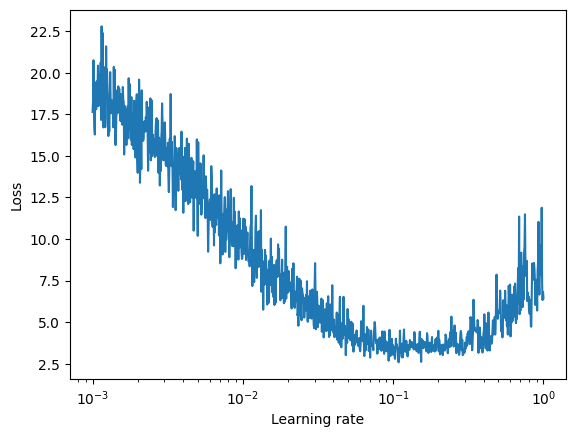

In [ ]:
# Determine the reasonable learning rate
mlp = MLP()
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

losses = []
lri = []

for lr in lrs:
    mlp.train(X, Y, epochs=1, lr=lr, batch_size=32)
    losses.append(mlp.loss.item())
    lri.append(lr)

plt.plot(lri, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.xscale("log")
plt.show()

In [15]:
# Seems like the learning rate 0.1 is reasonable
mlp = MLP()
mlp.train(X, Y, epochs=100000, lr=0.1, batch_size=32)

In [16]:
mlp.evaluate(X, Y)

2.352389097213745

In [17]:
# Let's do lerning rate decay
mlp.train(X, Y, epochs=10000, lr=0.001, batch_size=32)

In [18]:
# Much better than our bigram model!
mlp.evaluate(X, Y)

2.309046983718872